In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.linear_model import SGDRegressor, LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import joblib

# Exploratory Data Analysis and Model Building

In [23]:
df = pd.read_csv('static/2023_01_to_04.csv', index_col=0)
display(df.head())
print(df.shape)

,resale_price,year,month,timeseries_month,region,town,rooms,avg_storey,floor_area_sqm,remaining_lease,dist_to_marina_bay,latitude,longitude,nearest_station_0,dist_to_station0
_id,,,,,,,,,,,,,,,
150071,298000.0,2023,4,2023-04-01,North-East,Ang Mo Kio,2.0,8.0,44.0,53.750000,9.23,1.366227,103.850086,Ang Mo Kio MRT,0.41
152255,865000.0,2023,4,2023-04-01,North,Yishun,5.5,11.0,142.0,63.833333,14.89,1.415191,103.832902,Yishun MRT,1.59
152254,780000.0,2023,4,2023-04-01,North,Yishun,5.5,11.0,142.0,62.166667,16.13,1.425962,103.829779,Yishun MRT,0.70
152253,935000.0,2023,4,2023-04-01,North,Yishun,5.5,5.0,164.0,68.166667,15.54,1.421713,103.835545,Yishun MRT,0.86
152252,892000.0,2023,4,2023-04-01,North,Yishun,5.5,2.0,169.0,68.333333,17.08,1.436114,103.837605,Yishun MRT,0.79


(8859, 15)


## 1. EDA
### Summary of actions before training

1. Handling null values and Checking for collinearity
2. Preprocessing (mean encoding)
3. Feature selection (KBest, Lasso regression)
4. Model selection
5. Hyperparameter tuning 

### 1.1 Handling null values

In [25]:
#display(df[df['dist_to_station'].isna()])
df.dropna(inplace=True)

In [26]:
display(df.isna().sum())

resale_price          0
year                  0
month                 0
timeseries_month      0
region                0
town                  0
rooms                 0
avg_storey            0
floor_area_sqm        0
remaining_lease       0
dist_to_marina_bay    0
latitude              0
longitude             0
nearest_station_0     0
dist_to_station0      0
dtype: int64

### Explanation for each feature

| Feature*           | Explanation                                                                                     |
|-------------------|-------------------------------------------------------------------------------------------------|
| resale_price      | Dependent variable, the selling price of the flat                                               |
| region            | Region of the flat                                                                              |
| town              | Town district of the flat                                                                       |
| rooms             | Number of rooms in the flat (whole numbers except for 5.5, which represents an executive flat with an extra study/balcony) |
| avg_storey        | Mean value of the floor range (intervals of 3 storeys)                                          |
| floor_area_sqm    | Total floor area (in square meters) of the flat                                                 |
| remaining_lease   | Remaining lease of the flat in months                                                           |
| dist_to_marina_bay| Distance in absolute coordinates to Marina Bay (proxy to city center)                           |
| dist_to_station   | Distance in meters to the nearest MRT (Mass Rapid Transit) station                              |
| min_pt_time       | Time in seconds to reach the nearest MRT station by public transport and walking                |

*Other features not listed above but in DataFrame are for visual plotting purposes

### 1.1 Checking for collinearity among numerical features
* There is strong collinearity between 
    * floor_area_sqm and rooms (0.86)
    * dist_to_station and min_pt_time (0.69)
* Even much so higher than their correlation with output (resale price)
* For linear models, we need to remove one of each pair of feature to ensure that there is no multicollinearity, for this I will remove the feature with lower Pearson's correlation with our output
    * rooms (0.65)
    * min_pt_time (0.69)

<Axes: >

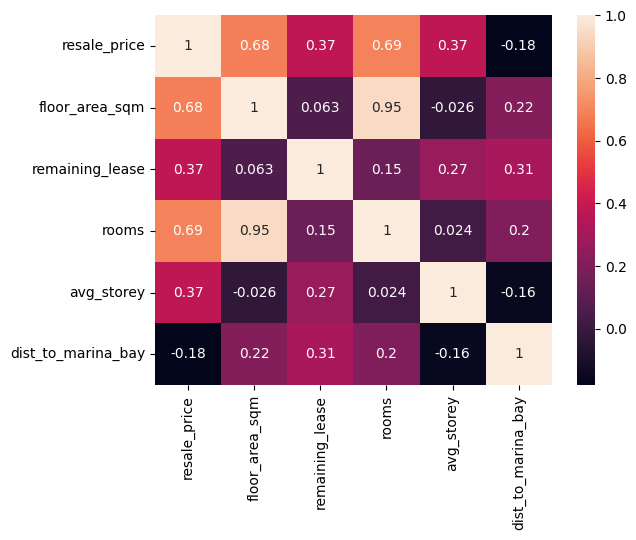

In [27]:
numerical_columns = df[['resale_price', 'floor_area_sqm', 'remaining_lease', 'rooms', 'avg_storey', 'dist_to_marina_bay']] #, 'dist_to_station', 'min_pt_time']]
sns.heatmap(numerical_columns.corr(), annot=True)

#### What are the most expensive neighbourhoods?

Each neighbourhood has a different mean price due to a non-exhaustive number of factors:

* location
* infrastructure and amenitites
* affluent / less affluent neighbourhoods
* supply and demand
* market speculation  

In [28]:
region_prices = df.groupby(['region', 'rooms'])[['resale_price']].median(numeric_only=True).sort_values(by=['region','rooms'], ascending=False)
region_prices = region_prices.unstack()
region_prices.columns = ['1 room', '2 room', '3 room', '4 room', '5 room', 'Executive', 'Mansionette']
region_prices.style.format(precision=0, thousands=',').highlight_max(color='red').highlight_min(color='green')

,1 room,2 room,3 room,4 room,5 room,Executive,Mansionette
region,,,,,,,
Central,"238,500","270,000","385,000","755,000","885,000","1,030,000",nan
East,nan,"346,500","389,444","542,000","656,500","840,000",nan
North,nan,"322,000","387,500","490,000","600,000","768,000","1,080,000"
North-East,nan,"330,000","406,500","560,888","650,000","820,000",nan
West,nan,"320,000","375,000","500,000","619,000","750,000",nan


In [29]:
town_prices = df.groupby(['town', 'rooms'])[['resale_price']].median(numeric_only=True).sort_values(by=['town','rooms'], ascending=False)
town_prices = town_prices.unstack()
town_prices.columns = ['1 room', '2 room', '3 room', '4 room', '5 room', 'Executive', 'Mansionette']
town_prices.style.format(precision=0, thousands=',').highlight_max(color='red').highlight_min(color='green')

,1 room,2 room,3 room,4 room,5 room,Executive,Mansionette
town,,,,,,,
Ang Mo Kio,nan,"289,900","380,000","560,000","780,000","933,000",nan
Bedok,nan,"285,000","365,000","490,000","660,000","870,000",nan
Bishan,nan,nan,"460,000","685,000","900,000","1,050,000",nan
Bukit Batok,nan,"339,000","370,000","590,000","760,000","820,000",nan
Bukit Merah,"238,500","270,000","394,000","815,000","870,000",nan,nan
Bukit Panjang,nan,"302,500","380,500","490,000","620,000","796,888",nan
Bukit Timah,nan,nan,"465,000","777,500","985,000","1,288,000",nan
Central Area,nan,"328,000","447,400","884,000","1,340,000",nan,nan
Choa Chu Kang,nan,"307,500","411,500","490,000","582,000","715,000",nan


#### Change in resale prices within year 2023

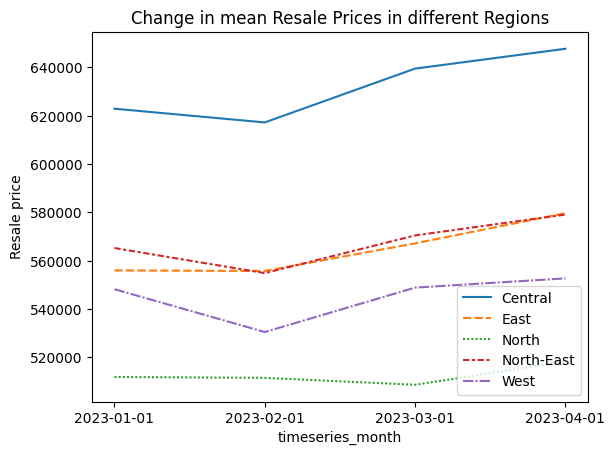

In [30]:
ma_df = df.groupby(['timeseries_month', 'region'])['resale_price'].mean()
ma_df = ma_df.unstack()
sns.lineplot(ma_df)
plt.title('Change in mean Resale Prices in different Regions')
plt.ylabel('Resale price')
plt.legend(loc='lower right')
plt.show()

### 1.2 Preprocessing (mean and label encoding)
* I will perform mean encoding (resale_price) onto the town and rooms.
* Take note that mean encoding may sometimes result in overfitting.

In [31]:
# Label encoding for town
encoder = LabelEncoder()
town_label = pd.Series(encoder.fit_transform(df['town']), name='town_encoded', index=df.index)

# Label encoding for region
region_label = pd.Series(encoder.fit_transform(df['region']), name='region_encoded', index=df.index)

Custom class for Mean/Median encoding

In [32]:
class MeanEncoder():
    '''
    Custom class encoder to deal with mean/median encoding
    '''
    def __init__(self, measure:str='mean'):
        self.encoder_dict_ = None
        self.columns_ = None
        self.measure_ = measure
        self.target_column_ = None

    def fit(self, X : pd.DataFrame, columns : list, target_column : str)->None:
        '''
        Fit to dataframe to create encoder_dict_ (dictionary) for data mapping
        ## Parameters
            X : pd.DataFrame object
            columns : list of strings, indicating columns to groupby
            target_column : str, desired output (must be numeric)
        Returns None
        '''
        self.columns_ = columns
        self.target_column_ = target_column
        if self.measure_ == 'mean':
            self.encoder_dict_ = X.groupby(self.columns_)[self.target_column_].mean(numeric_only=True).to_dict()
        elif self.measure_ == 'median':
            self.encoder_dict_ = X.groupby(self.columns_)[self.target_column_].median(numeric_only=True).to_dict()
    
    def transform(self, X : pd.DataFrame)->pd.Series:
        '''
        Transform dataframe by mapping data using encoder_dict_
        ## Parameters
            X : pd.DataFrame object
        Returns pd.Series of encoded data
        '''
        def columns_to_tuple(df, columns):
            '''
            Function to combined columns as a tuple for dictionary mapping
            '''
            temp = []
            for column in columns:
                temp.append(df[column])
            return tuple(temp)
        
        row_tuple = X.apply(columns_to_tuple, columns = self.columns_, axis=1)
        row_tuple.name = f'{self.measure_}_encoded'
        output =  row_tuple.map(self.encoder_dict_)
        return output

In [33]:
#  Median encoding on towns and rooms
median_encoder = MeanEncoder(measure='median')
median_encoder.fit(df, columns=['town', 'rooms'], target_column='resale_price')
town_median_price = median_encoder.transform(df)

#  Mean encoding on towns and rooms
mean_encoder = MeanEncoder(measure='mean')
mean_encoder.fit(df, columns=['town', 'rooms'], target_column='resale_price')
town_mean_price = mean_encoder.transform(df)

train_df = pd.concat([numerical_columns, town_median_price, town_mean_price, town_label, region_label], axis =1)
train_df.head()

,resale_price,floor_area_sqm,remaining_lease,rooms,avg_storey,dist_to_marina_bay,median_encoded,mean_encoded,town_encoded,region_encoded
_id,,,,,,,,,,
150071,298000.0,44.0,53.750000,2.0,8.0,9.23,289900.0,293168.800000,0,3
152255,865000.0,142.0,63.833333,5.5,11.0,14.89,800000.0,838167.676364,25,2
152254,780000.0,142.0,62.166667,5.5,11.0,16.13,800000.0,838167.676364,25,2
152253,935000.0,164.0,68.166667,5.5,5.0,15.54,800000.0,838167.676364,25,2
152252,892000.0,169.0,68.333333,5.5,2.0,17.08,800000.0,838167.676364,25,2


### 1.3 Feature selection

In [34]:
X_unscaled = train_df.iloc[:,1:]
y = train_df.iloc[:,0]
scaler = MinMaxScaler()
X = scaler.fit_transform(X_unscaled)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

SelectKBest using Mutual Information

In [35]:
X_df = pd.DataFrame(X, columns=X_unscaled.columns)
kbest = SelectKBest(score_func=mutual_info_regression, k='all')
kbest.fit(X_df, y)
pd.DataFrame(kbest.scores_, index=kbest.get_feature_names_out(kbest.feature_names_in_), columns=['Mutual Info Score'])

,Mutual Info Score
floor_area_sqm,0.732128
remaining_lease,0.329396
rooms,0.532034
avg_storey,0.088830
dist_to_marina_bay,0.251546
median_encoded,0.868921
mean_encoded,0.888959
town_encoded,0.211584
region_encoded,0.103505


Lasso regularisation to determine less important features

In [36]:
# LassoCV here uses crossvalidation to determine the optimum alpha (penalty value)
lr_reg1 = LassoCV(random_state=42)
lr_reg1.fit(X_train, y_train)
r2 = r2_score(y_test, lr_reg1.predict(X_test))
print(f'LassoCV Alpha: {np.round(lr_reg1.alpha_,3)}')
print(f'R2 score: {np.round(r2,3)}')
print()
print('Scaled weights for comparison')

feature_scaler = MinMaxScaler()
scaled_f_importances = feature_scaler.fit_transform(lr_reg1.coef_.reshape(-1,1))
display(pd.DataFrame(scaled_f_importances, index=X_unscaled.columns, columns=['Features']))

LassoCV Alpha: 20.221
R2 score: 0.883

Scaled weights for comparison


,Features
floor_area_sqm,0.998547
remaining_lease,0.505232
rooms,0.000000
avg_storey,0.519582
dist_to_marina_bay,0.119416
median_encoded,0.179666
mean_encoded,1.000000
town_encoded,0.254826
region_encoded,0.242575


## Final selection of features

Based on the EDA, KBest and LassoCV done so far, the following features will be excluded:
* rooms (to utilise in mean encoding instead)
* dist_to_station
* median_encoded 
* town_encoded 
* region_encoded 

Mean encoding works the best, hence we will not consider the label encoded features and median encoded prices.

In [37]:
X_unscaled = train_df[['floor_area_sqm', 'remaining_lease', 'avg_storey', 'dist_to_marina_bay', 'mean_encoded']] #, 'min_pt_time'
y = train_df.iloc[:,0]
scaler = MinMaxScaler()
X = scaler.fit_transform(X_unscaled)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 1.4 Model Selection
We will compare the following models in general, before hyperparameter tuning
* SGD Regressor
* Decision Tree Regressor
* Random Forest Regressor
* Gradient Boosting Regressor

In [38]:
models = {'SGD Regressor' : SGDRegressor(random_state=42),
          'Tree Regressor' : DecisionTreeRegressor(random_state=42),
          'Random Forest Regressor' : RandomForestRegressor(random_state=42), 
          'Gradient Boosting Regressor' : GradientBoostingRegressor(random_state=42)}

for name, model in models.items():
    model.fit(X_train, y_train)
    r2 = r2_score(y_test, model.predict(X_test))
    print(f'R2 score for {name}: {np.round(r2,3)}')

R2 score for SGD Regressor: 0.876
R2 score for Tree Regressor: 0.913
R2 score for Random Forest Regressor: 0.948
R2 score for Gradient Boosting Regressor: 0.928


In [39]:
feature_importances = {}
for name, model in models.items():
    if name == 'SGD Regressor':
        continue
    feature_importances[name]= model.feature_importances_

print('Feature Importances')
display(pd.DataFrame(feature_importances, index=X_unscaled.columns))

Feature Importances


,Tree Regressor,Random Forest Regressor,Gradient Boosting Regressor
floor_area_sqm,0.173493,0.163612,0.106318
remaining_lease,0.142669,0.132366,0.136929
avg_storey,0.026634,0.031707,0.037626
dist_to_marina_bay,0.067113,0.065049,0.039756
mean_encoded,0.590092,0.607266,0.679371


# New ideas

In [40]:
# Add permutation importances
# impurity-based importances are biased towards high cardinality features
# min_samples_leaf in gridsearch
# plot out tree to see if overfitted

The ensemble models (Random Forest and Gradient Boosting) tend to perform better. 
I will narrow down to tune these two models for now.

### 1.5 Hyperparameter tuning
Randomized Search Cross-Validation to tune the hyperpameters for the top 2 models

#### Random Forest Regressor

In [41]:
param_distributions = {'max_depth' : [None, 3,5,7,9],
                       'n_estimators' : [50,100,150],
                       'min_samples_leaf' : [50, 100, 150]
                       }

random_cv = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42),
                               scoring= 'r2', 
                               param_distributions= param_distributions, 
                               n_iter= 15,
                               cv= 5, 
                               verbose= 1,
                               n_jobs=2)

random_cv.fit(X, y)
print('Best Parameters', random_cv.best_params_)
print('Best R2 score', np.round(random_cv.best_score_,3))
best_rfr = random_cv.best_estimator_


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters {'n_estimators': 50, 'min_samples_leaf': 50, 'max_depth': 7}
Best R2 score 0.882


#### Gradient Boosting Regressor

In [42]:
param_distributions = {'max_depth' : [None, 3,5,7,9],
                       'n_estimators' : [50,100,150],
                       'learning_rate' : [0.01,0.1,1]
                       }

random_cv = RandomizedSearchCV(estimator=GradientBoostingRegressor(random_state=42),
                               scoring= 'r2', 
                               param_distributions= param_distributions, 
                               n_iter= 15,
                               cv= 5, 
                               verbose= 1,
                               n_jobs=2)

random_cv.fit(X, y)
print('Best Parameters', random_cv.best_params_)
print('Best R2 score', np.round(random_cv.best_score_,3))
best_gbc = random_cv.best_estimator_


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters {'n_estimators': 50, 'max_depth': 9, 'learning_rate': 0.1}
Best R2 score 0.945


## Test on subsequent month's data (Unseen)

In [44]:
test_df = pd.read_csv('static/2023_05.csv', index_col=0)

# Use previous dictionary of the town and rooms for mean encoding
mean_encoded = mean_encoder.transform(test_df)
test_df = pd.concat([test_df, mean_encoded], axis =1)
test_df = test_df[['resale_price','floor_area_sqm', 'remaining_lease', 'avg_storey', 'dist_to_marina_bay', 'mean_encoded']]
display(test_df.head())
print(test_df.shape)

,resale_price,floor_area_sqm,remaining_lease,avg_storey,dist_to_marina_bay,mean_encoded
_id,,,,,,
152256,275000.0,44.0,53.75,2.0,9.23,293168.800000
152257,300000.0,45.0,61.75,8.0,10.45,293168.800000
152258,348000.0,67.0,53.75,11.0,9.62,399997.149425
152259,330000.0,68.0,56.75,2.0,10.17,399997.149425
152260,400000.0,67.0,54.75,8.0,9.38,399997.149425


(2063, 6)


In [45]:
X_test = test_df.iloc[:,1:]
y_test = test_df.iloc[:,0]
X_test = scaler.transform(X_test)

r2 = r2_score(y_test, best_rfr.predict(X_test))
print(f'R2 score for Random Forest Regressor: {np.round(r2,3)}')

r2 = r2_score(y_test, best_gbc.predict(X_test))
print(f'R2 score for Gradient Boosting Regressor: {np.round(r2,3)}')

R2 score for Random Forest Regressor: 0.877
R2 score for Gradient Boosting Regressor: 0.947


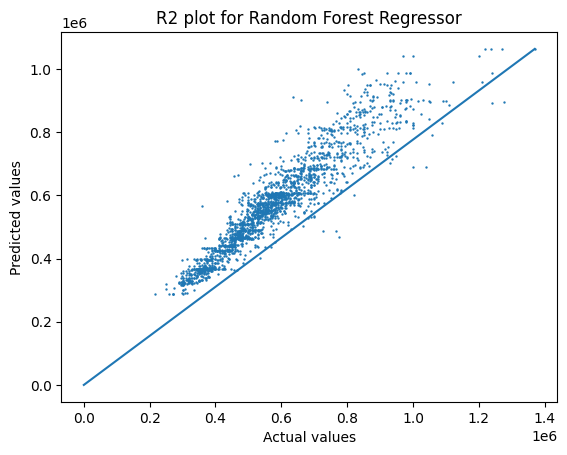

In [46]:
# Plot r2 graphs
y_pred = best_rfr.predict(X_test)
plt.scatter(y_test, y_pred , marker='.', s=2)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.plot([0,max(y_test)], [0, max(y_pred)])
plt.title('R2 plot for Random Forest Regressor')
plt.show()

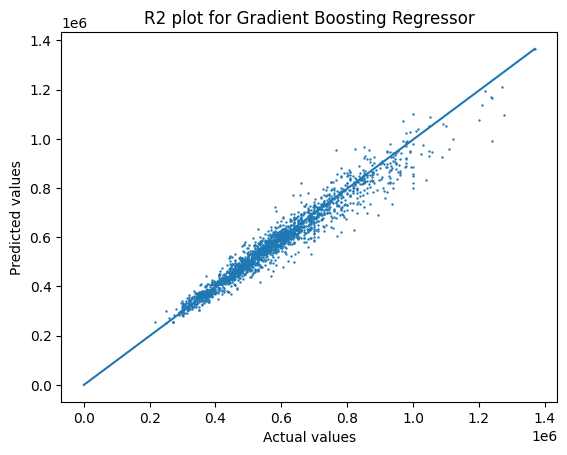

In [47]:
# Plot r2 graphs
y_pred = best_gbc.predict(X_test)
plt.scatter(y_test, y_pred , marker='.', s=2)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.plot([0,max(y_test)], [0, max(y_pred)])
plt.title('R2 plot for Gradient Boosting Regressor')
plt.show()

## Exporting the objects for deployment

In [49]:
print(joblib.dump(scaler, 'models/scaler.joblib'))
print(joblib.dump(mean_encoder, 'models/mean_encoder.joblib'))

['models/scaler.joblib']


['models/mean_encoder.joblib']

In [129]:
name = input(f'Name save file for model {best_gbc}\n')
if name != '':
    filepath = f'models/gbc_{name}.joblib'
    joblib.dump(best_gbc, filepath)
    print(f'File saved as {filepath}')

name = input(f'Name save file for model {best_rfr}\n')
if name != '':
    filepath = f'models/rfr_{name}.joblib'
    joblib.dump(best_rfr, filepath)
    print(f'File saved as {filepath}')



File saved as models/gbc_2023_01_to_04.joblib
File saved as models/rfr_2023_01_to_04.joblib
